In [193]:
"""The first 2 cells preprocess the data given. First the data is extracted from the text file. Then the newline character is
removed and the data is split on every blank space.
"""
c1 = []
c2 = []
with open('data_files/Train1.txt', 'r') as f:
    data = f.readlines()
    
for i in data:    
    i = i.replace("\n","")
    i = i.split("  ")
    c1.append([float(j) for j in i])
c1 = np.asarray(c1)
    
with open('data_files/Train2.txt', 'r') as f:
    data = f.readlines()

for i in data:    
    i = i.replace("\n","")
    i = i.split("  ")
    c2.append([float(j) for j in i])
c2 = np.asarray(c2)


In [194]:
tc1 = []
tc2 = []
with open('data_files/Test1.txt', 'r') as f:
    data = f.readlines()
    
for i in data:    
    i = i.replace("\n","")
    i = i.split("  ")
    tc1.append([float(j) for j in i])
tc1 = np.asarray(c1)
    
with open('data_files/Test2.txt', 'r') as f:
    data = f.readlines()


for i in data:    
    i = i.replace("\n","")
    i = i.split("  ")
    tc2.append([float(j) for j in i])
tc2 = np.asarray(c2)

In [195]:
def normalize_samples(samples):
    return (samples - samples.mean(axis=0))/samples.std(axis=0)

In [196]:
# the data is normalized by subtracting mean from each value and dividing with variance
c1 = normalize_samples(c1)
c2 = normalize_samples(c2)
tc1 = normalize_samples(tc1)
tc2 = normalize_samples(tc2)

In [197]:
# The labels column is added to the data.
y1 = np.zeros((c1.shape[0], 1), dtype='int')
c1 = np.hstack((c1, y1))
y2 = np.ones((c2.shape[0], 1), dtype='int')
c2 = np.hstack((c2, y2))
ty1 = np.zeros((tc1.shape[0], 1), dtype='int')
tc1 = np.hstack((tc1, y1))
ty2 = np.ones((tc2.shape[0], 1), dtype='int')
tc2 = np.hstack((tc2, y2))

In [198]:
# we merge the 2 class data and divide the data into train test and validation
train_set = np.vstack((c1[:1500],c2[:1500]))
val_set = np.vstack((c1[1500:],c2[1500:]))
test_set = np.vstack((tc1,tc2))

In [199]:
X,Y = train_set[:, [0,1]],train_set[:, [2]]
print(X.shape)
print(Y.shape)

(3000, 2)
(3000, 1)


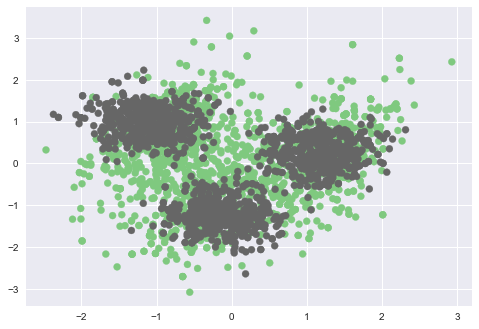

In [200]:
# we are plotting the x1 and x2 features of the data
# observe that the coordinates are highly overlapping for class 1 and 2 and class 2 data is actually divided into 3 neat clusters.
plt.style.use("seaborn")
plt.scatter(X[:,0],X[:,1],c=Y,cmap=plt.cm.Accent)

plt.show()

In [201]:
import numpy as np
import matplotlib.pyplot as plt

class MLP:
    
    """initialize the weights and bias. Note that the weight matrix shape is very important. THe weights from input to hidden
    would be (2,hidden_nodes) since we have 2 input nodes and the weight matrix shape from hidden to output would be 
    (hidden_nodes,1) since there is only one output node.
    """
    def __init__(self, hidden_nodes, learning_rate=0.01):
        self.learning_rate = learning_rate
        self.hidden_nodes = hidden_nodes
        self.w1_2 = np.random.rand(2, self.hidden_nodes)
        self.b1 = np.zeros((1, self.hidden_nodes))
        self.w2_3 = np.random.rand(self.hidden_nodes, 1)
        self.b2 = np.zeros((1, 1))
    
    #forward prop basically involves just doing a dot product between input and weight matrix
    def forward_prop_node(self,x,w,b):  
        return np.dot(x, w) + b
    
    # we are using sigmoid activation function after each layer. This function introduces the non linearity into the model.
    def act_sig(self,x):    
        return 1.0/(1.0 + np.exp(-x))
    
    # the error metric used to measure loss is mean square error defined here
    def mse(self,pred,label):
        return np.sum((((pred-label)**2))/(2*len(label)))
    
    #the forward calculations involve using the forward prop node function for getting the linear equation value for each node
    # and runnning the output of the nodes in the layer through the activation function.
    def forward(self, X):
        self.i_h = self.forward_prop_node(X,self.w1_2,self.b1)
        self.h_act = self.act_sig(self.i_h)
        self.h_o = self.forward_prop_node(self.h_act,self.w2_3,self.b2)
        self.o_act = self.act_sig(self.h_o)
        return self.o_act

    """This is the most important part of an MLP. The backpropogation step involves calculating the gradient of the error with 
    respect to the weights given. Note that this cannot be done directly since error does not have weight in its equation. 
    So we use partial differentiation and differentiation by parts on each part of the node (output before activation, 
    activation output and error equation) This step is usually extremely complex when there are a lot of layers involved. But
    in our case since its a 1 hidden layer network it can be calculated directly. 
    Ref: https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/"""
    
    def backprop(self, X, y, output):
        error = y - output
        pd_out = error * output * (1 - output)
        h_error = pd_out.dot(self.w2_3.T)
        pd_h = h_error * self.h_act * (1 - self.h_act)

        self.w1_2 += X.T.dot(pd_h) * self.learning_rate
        self.w2_3 += self.h_act.T.dot(pd_out) * self.learning_rate
        
    #Since our output is a number between 0 and 1, our classes are assigned as follows: value>0.5 => class 2 else class 1    
    def cl(self,pred):
        pr = []
        for i in pred:
            if i >= 0.5:
                pr.append([1])
            else:
                pr.append([0])
        pr = np.asarray(pr)
        return pr
    
    #accuracy is simply labels predicted correctly/total labels
    def accuracy(self,pred,label):
        cnt = 0
        for i in range(len(label)):
            if(pred[i]==label[i]):
                cnt+=1
        return cnt/len(label)
        
        
    #we will be plotting the loss with respect to epochs
    def plots(self, epochs, train_loss, val_loss, test_loss):
        
        plt.figure(figsize=(22, 5))

        plt.plot(epochs, train_loss, label='Train_Loss', color='red')
        plt.plot(epochs, val_loss, label='Val_Loss', color='yellow')
        plt.plot(epochs, test_loss, label='Test_Loss', color='green')
        plt.title('Loss curve')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

    # this function brings together all the steps in the model: 
    # Perform forward prop over the given data
    # Obtain error
    # perform backprop to update the weights based on the gradient and learning rate
    # observe the train loss
    # Do a test on validation set to observe the accuracy change. If the validation loss stops decreasing you can stop training
    # Obsrve the loss and accuracy in test.
    def train_network(self, train, train_label, val, val_label, test, test_label, epochs=2500):

        train_loss, val_loss, test_loss = [], [], []
        ep = []

        val_loss_prev = 999999999
        
        for i in range(epochs):
            
            train_output = self.forward(train)
            self.backprop(train, train_label, train_output)
            train_loss_value = self.mse(train_output,train_label)
            train_loss.append(train_loss_value)

            val_output = self.forward(val)
            val_loss_value = self.mse(val_output,val_label)
            val_loss.append(val_loss_value)

            test_output = self.forward(test)
            test_loss_value = self.mse(test_output,test_label)
            test_loss.append(test_loss_value)


            train_acc = self.accuracy(self.cl(train_output),train_label)
            val_acc = self.accuracy(self.cl(val_output),val_label)
            test_acc = self.accuracy(self.cl(test_output),test_label)

            ep.append(i)

            if val_loss_value >= val_loss_prev:
                break

            prev_val_loss = val_loss_value
            

        print(f'Epoch {epochs}, Train Loss: {train_loss_value}, Val Loss: {val_loss_value}, Test Loss: {test_loss_value},Train Accuracy: {train_acc}, validation Accuracy: {val_acc}, Test Accuracy: {test_acc}')
        self.plots(ep, train_loss, val_loss, test_loss)


hidden nodes = 4
Epoch 2500, Train Loss: 0.10408867084297585, Val Loss: 0.10721182131697746, Test Loss: 0.10486497292341618,Train Accuracy: 0.6823333333333333, validation Accuracy: 0.66, Test Accuracy: 0.67675


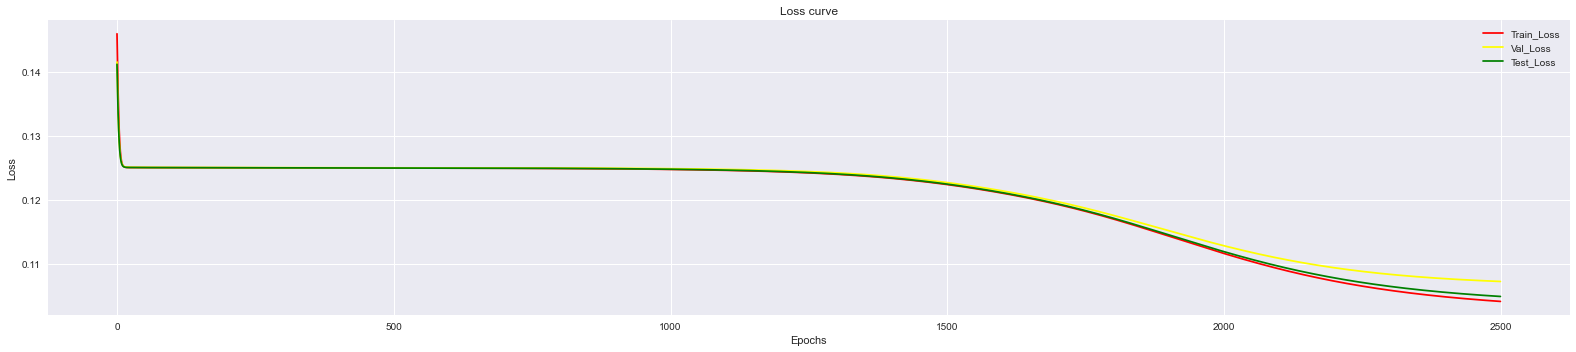


hidden nodes = 8
Epoch 2500, Train Loss: 0.10098438262662643, Val Loss: 0.10607766362526946, Test Loss: 0.10225646868787532,Train Accuracy: 0.6976666666666667, validation Accuracy: 0.667, Test Accuracy: 0.69


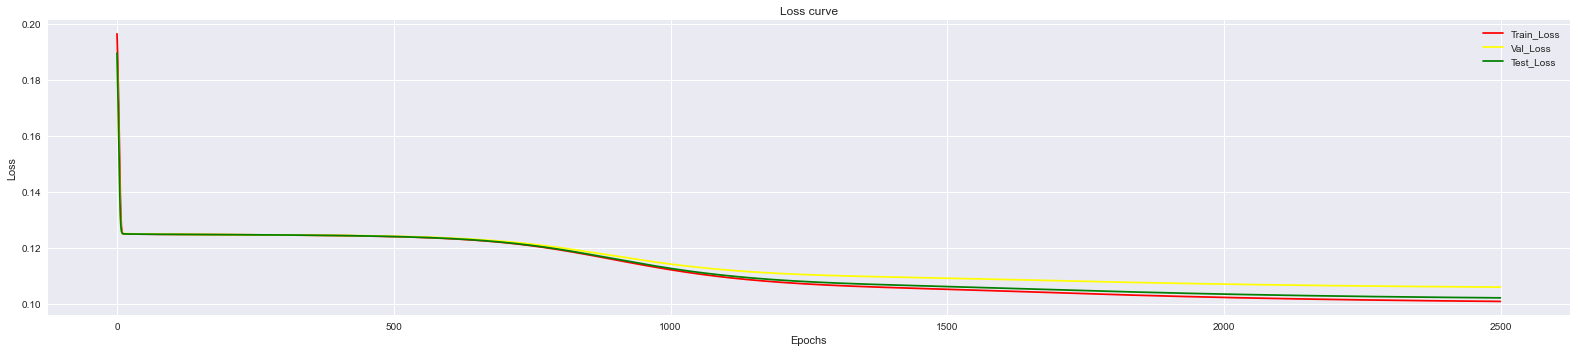


hidden nodes = 10
Epoch 2500, Train Loss: 0.10203077790328796, Val Loss: 0.10641860678555698, Test Loss: 0.10312728850245226,Train Accuracy: 0.6923333333333334, validation Accuracy: 0.67, Test Accuracy: 0.68675


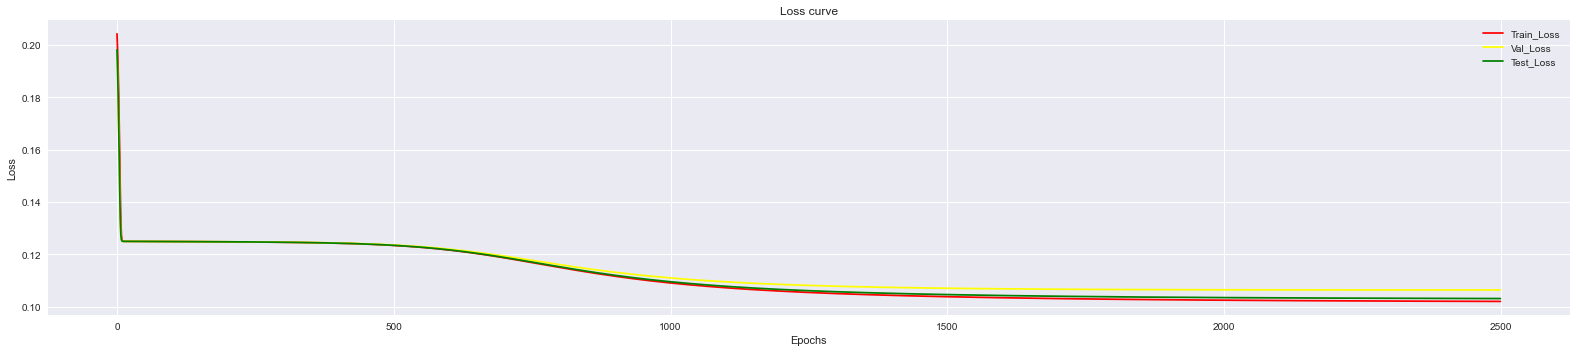


hidden nodes = 12
Epoch 2500, Train Loss: 0.10176867963755104, Val Loss: 0.10630542871481315, Test Loss: 0.10290267562005323,Train Accuracy: 0.6966666666666667, validation Accuracy: 0.67, Test Accuracy: 0.69


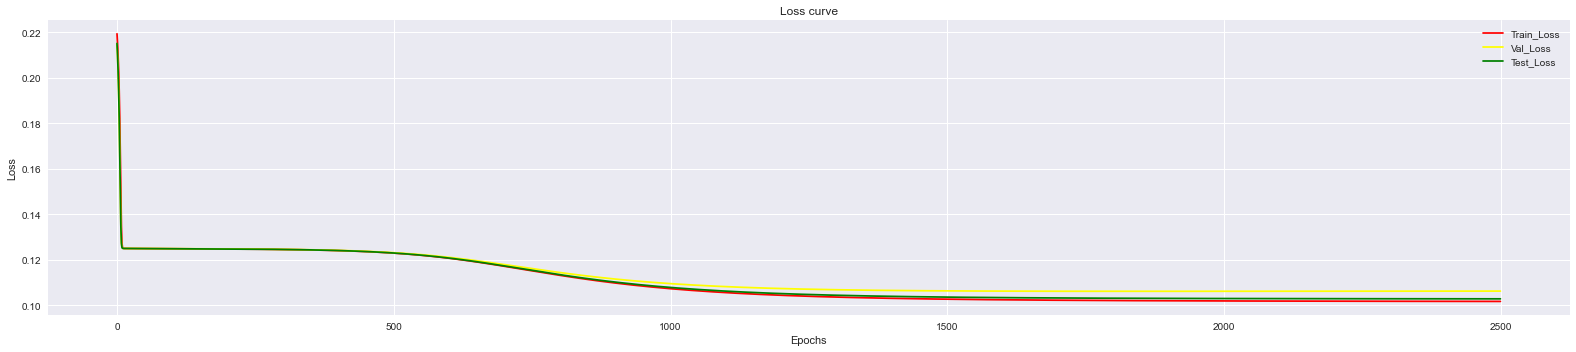


hidden nodes = 14
Epoch 2500, Train Loss: 0.10127924847259516, Val Loss: 0.10602423485322293, Test Loss: 0.10246437398389563,Train Accuracy: 0.6976666666666667, validation Accuracy: 0.677, Test Accuracy: 0.6925


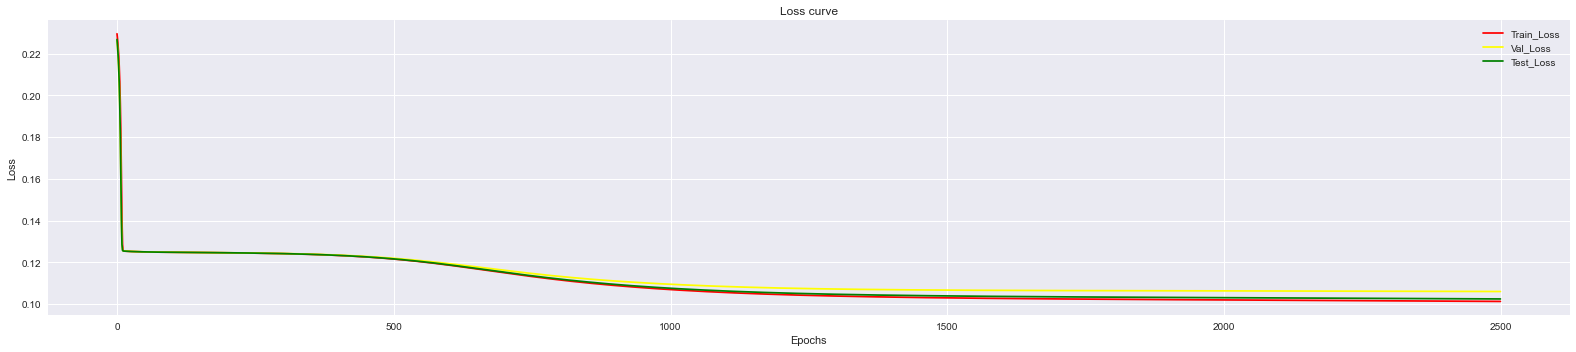

In [202]:

learning_rate = 0.001
hidden_layer_nodes = [4, 8, 10, 12, 14]

for h_nodes in hidden_layer_nodes:
    print(f"\nhidden nodes = {h_nodes}")

    neural_network = MLP(h_nodes, learning_rate)
   
    train, train_label = train_set[:, :-1], train_set[:, -1].reshape(-1, 1)
    validation, val_label = val_set[:, :-1], val_set[:, -1].reshape(-1, 1)
    test, test_label = test_set[:, :-1], test_set[:, -1].reshape(-1, 1)

    neural_network.train_network(train, train_label, validation, val_label, test, test_label)



## Part B

In [203]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Activation
from tensorflow.keras.utils import to_categorical

def modify_model_params(kernel_size = 3, fcn_start_size = 128, feature_start_size = 16,lr = None):
    model = Sequential()

    model.add(Conv2D(feature_start_size,activation = 'relu', kernel_size=(kernel_size, kernel_size), strides=(1, 1), input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
    model.add(Conv2D(feature_start_size*2,activation = 'relu', kernel_size=(kernel_size, kernel_size), strides=(1, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
    model.add(Flatten())
    model.add(Dense(fcn_start_size,activation = 'relu'))
    model.add(Dense(fcn_start_size/2,activation = 'relu'))
    model.add(Dense(10, activation="softmax"))
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"])
    if lr != None:
        model.optimizer.learning_rate.assign(lr)
    return model

In [204]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [205]:
#default model
default_model = modify_model_params()
default_model.fit(x_train,y_train,batch_size=32,epochs = 10)
_,accuracy = default_model.evaluate(x_test, y_test)
print(f"Accuracy of the modelwith default params is {accuracy}")

Epoch 1/10
1875/1875 [==============================] - 20s 5ms/step - loss: 0.2633 - accuracy: 0.9171
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0415 - accuracy: 0.9884
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0312 - accuracy: 0.9912
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0259 - accuracy: 0.9930
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0238 - accuracy: 0.9931
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0195 - accuracy: 0.9951
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0156 - accuracy: 0.9959
Epoch 8/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0188 - accuracy: 0.9958
Epoch 9/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0138 - accuracy: 0.9968
Epoch 10/10
313/313 [==============================] - 1s 2ms/step - loss: 0.0816

In [206]:
lr_01_model = modify_model_params(lr = 0.01)
lr_01_model.fit(x_train,y_train,batch_size=32,epochs = 10)
_,accuracy = lr_01_model.evaluate(x_test, y_test)
print(f"Accuracy of the modelwith learning rate 0.01 params is {accuracy}")

Epoch 1/10
1875/1875 [==============================] - 9s 4ms/step - loss: 0.6984 - accuracy: 0.8868
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2060 - accuracy: 0.9571
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2189 - accuracy: 0.9560
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2264 - accuracy: 0.9576
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3449 - accuracy: 0.9564
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2397 - accuracy: 0.9586
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3362 - accuracy: 0.9535
Epoch 8/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2713 - accuracy: 0.9523
Epoch 9/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3177 - accuracy: 0.9492
Epoch 10/10
313/313 [==============================] - 1s 2ms/step - loss: 0.2432 

In [207]:
lr_0001_model = modify_model_params(lr = 0.0001)
lr_0001_model.fit(x_train,y_train,batch_size=32,epochs = 10)
_,accuracy = lr_0001_model.evaluate(x_test, y_test)
print(f"Accuracy of the modelwith learning rate 0.0001 params is {accuracy}")

Epoch 1/10
1875/1875 [==============================] - 9s 4ms/step - loss: 0.4408 - accuracy: 0.8762
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0769 - accuracy: 0.9769
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0493 - accuracy: 0.9845
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0374 - accuracy: 0.9887
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0304 - accuracy: 0.9909
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0241 - accuracy: 0.9924
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0209 - accuracy: 0.9934
Epoch 8/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0169 - accuracy: 0.9950
Epoch 9/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0168 - accuracy: 0.9954
Epoch 10/10
313/313 [==============================] - 1s 2ms/step - loss: 0.0390 

In [208]:
kernel5_model = modify_model_params(kernel_size=5)
kernel5_model.fit(x_train,y_train,batch_size=32,epochs = 10)
_,accuracy = kernel5_model.evaluate(x_test, y_test)
print(f"Accuracy of the model with kernel size 5 is {accuracy}")

Epoch 1/10
1875/1875 [==============================] - 9s 4ms/step - loss: 0.2187 - accuracy: 0.9291
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0457 - accuracy: 0.9864
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0366 - accuracy: 0.9896
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0292 - accuracy: 0.9921
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0291 - accuracy: 0.9928
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0274 - accuracy: 0.9941
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0266 - accuracy: 0.9946
Epoch 8/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0219 - accuracy: 0.9955
Epoch 9/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0226 - accuracy: 0.9958
Epoch 10/10
313/313 [==============================] - 1s 2ms/step - loss: 0.0783 

In [209]:
kernel2_model = modify_model_params(kernel_size=2)
kernel2_model.fit(x_train,y_train,batch_size=32,epochs = 10)
_,accuracy = kernel2_model.evaluate(x_test, y_test)
print(f"Accuracy of the model with kernel size 2 is {accuracy}")

Epoch 1/10
1875/1875 [==============================] - 9s 4ms/step - loss: 0.2806 - accuracy: 0.9118
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0451 - accuracy: 0.9867
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0302 - accuracy: 0.9906
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0243 - accuracy: 0.9933
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0180 - accuracy: 0.9946
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0167 - accuracy: 0.9956
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0115 - accuracy: 0.9967
Epoch 8/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0129 - accuracy: 0.9971
Epoch 9/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0101 - accuracy: 0.9973
Epoch 10/10
313/313 [==============================] - 1s 2ms/step - loss: 0.0830 

In [210]:
fcn4_model = modify_model_params(fcn_start_size=4)
fcn4_model.fit(x_train,y_train,batch_size=32,epochs = 10)
_,accuracy = fcn4_model.evaluate(x_test, y_test)
print(f"Accuracy of the model with fcn neurons 4 and 2  is {accuracy}")

Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 1.9777 - accuracy: 0.2087
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 1.6709 - accuracy: 0.3066
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 1.5047 - accuracy: 0.3965
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 1.3121 - accuracy: 0.4576
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 1.1431 - accuracy: 0.5715
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 1.0340 - accuracy: 0.6103
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.9563 - accuracy: 0.6240
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.8879 - accuracy: 0.6362
Epoch 9/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.8260 - accuracy: 0.6514
Epoch 10/10
313/313 [==============================] - 1s 2ms/step - loss: 0.8071 

In [211]:
feature_size_8_model = modify_model_params(feature_start_size=8)
feature_size_8_model.fit(x_train,y_train,batch_size=32,epochs = 10)
_,accuracy = feature_size_8_model.evaluate(x_test, y_test)
print(f"Accuracy of the model with starting feature size 8 is  {accuracy}")

Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2723 - accuracy: 0.9156
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0547 - accuracy: 0.9835
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0348 - accuracy: 0.9894
Epoch 4/10
1875/1875 [==============================] - ETA: 0s - loss: 0.0282 - accuracy: 0.99 - 7s 4ms/step - loss: 0.0282 - accuracy: 0.9914
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0211 - accuracy: 0.9939
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0195 - accuracy: 0.9950
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0173 - accuracy: 0.9956
Epoch 8/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0145 - accuracy: 0.9962
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0135 - accuracy: 0.9963
Epoch 10/10
313/313 [===================

In [212]:
feature_size_64_model = modify_model_params(feature_start_size=64)
feature_size_64_model.fit(x_train,y_train,batch_size=32,epochs = 10)
_,accuracy = feature_size_64_model.evaluate(x_test, y_test)
print(f"Accuracy of the model with starting feature size 64  is  {accuracy}")

Epoch 1/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.2348 - accuracy: 0.9252
Epoch 2/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0442 - accuracy: 0.98770s - loss:
Epoch 3/10
1875/1875 [==============================] - 18s 9ms/step - loss: 0.0352 - accuracy: 0.9908
Epoch 4/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0305 - accuracy: 0.9926
Epoch 5/10
1875/1875 [==============================] - 18s 9ms/step - loss: 0.0288 - accuracy: 0.9931
Epoch 6/10
1875/1875 [==============================] - 18s 9ms/step - loss: 0.0262 - accuracy: 0.9934
Epoch 7/10
1875/1875 [==============================] - 18s 9ms/step - loss: 0.0273 - accuracy: 0.9942
Epoch 8/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0224 - accuracy: 0.9953
Epoch 9/10
1875/1875 [==============================] - 18s 9ms/step - loss: 0.0202 - accuracy: 0.9961
Epoch 10/10
313/313 [==============================] - 1s 3